<a href="https://colab.research.google.com/github/MingSheng92/ImageRecognition_with_TensorFlow/blob/main/CNN_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting started**

In this notebook, we are creating a convolutional neural network to solve image classification problem.

I will keep all the class and functions at the top section and calling the afterwards. For me personally I like to upload the source python file onto github and load it with magic functions so that I can keep the notebook with least amount of codes.

### Import Libraries and source code

In [11]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
from  PIL import Image

Here we have all the utility functions that we will use in later segment.

We have the following functions:
- loadDataset(): To load the dataset from keras and perform basic data transformation.   
- normalized(): Here we normalized the pixel value to range from 0 - 1.
$ z = \frac{x - min(x)}{max(x)- min(x)} $
 Since we know that a pixel value ranges from 0 - 255, another alternatives is to directly divide the value by 255.  
- tf_one_hot_enc(): In order to train our multiclass cnn model, we will need to one hot encode the class label before we feed it into the model for training.
- plotImage(): A simple function to plot out the first-N images in the dataset.
- plotModelAcc(): Function to plot the test and validation accuracy during training.
- plotModelLost(): Function to plot the test and validation loss during training.

Even though the dataset has already done some conversion for us, labels has already been convert to numbers.

- T-shirt => 0 
- Trouser => 1
- Pullover => 2
- dress => 3
- coat => 4 
- sandal => 5
- shirt => 6
- sneaker => 7 
- bag => 8 
- ankle boots => 9

But we will need to perform one hot encoding to the converted labels. For example:
- T-shirt => [1 0 0 0 0 0 0 0 0 0] 
- sandal => [0 0 0 0 0 1 0 0 0 0]

Notice that after one-hot encoding T-shirt has 1 is at index 0, which indicates this is class 0, and the apply for the rest of the classes.

In [30]:
# simple load data function
def loadDataset():
  # input image dimensions
  img_rows, img_cols = 28, 28

  # load dataset from tensorflow
  fashion_mnist = tf.keras.datasets.fashion_mnist
  # it will return the training and test data
  (train_feature, train_labels), (test_feature, test_labels) = fashion_mnist.load_data()

  # reshape loaded dataset back to original image size for later usage
  train_feature = train_feature.reshape(-1, img_rows, img_cols, 1)
  test_feature = test_feature.reshape(-1, img_rows, img_cols, 1)
  
  # return the reshape image data 
  return (train_feature, train_labels), (test_feature, test_labels)

# to normalize the image data to scale from 0 - 1
def normalize(data):
	# return normalized data
	return (data - np.min(data))/(np.max(data) - np.min(data))

# we use this function to perform one hot encoding to the predict labels 
def tf_one_hot_enc(labels):
  # depth is based on total number of class
  depth = len(np.unique(labels))

  # return one hot encoded arrays 
  return tf.one_hot(labels, depth)

# plot image
def plotImage(first_n, dataset):
  # plot first few images
  for i in range(first_n):
    imgData = dataset[i].squeeze(axis=2)
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(imgData, cmap=plt.get_cmap('gray'))
   
  # show the figure
  plt.show()

def plotModelAcc(hist):
  # summarize history for accuracy
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def plotModelLoss(hist):
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def plot_predictions(images, predictions, true_labels, correct=True):
  # constant 
  FM_LABEL = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

  label_string = "correct"
  incorrect = np.where(predictions==true_labels)[0]
  if not correct:
    label_string = "incorrect"
    incorrect = np.where(predictions!=true_labels)[0]

  print("Found {} {} labels" .format(len(incorrect), label_string))
  
  for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(images[incorrect].reshape(28,28), interpolation='none')
    plt.title("{}, {}".format(FM_LABEL[predictions[incorrect]], FM_LABEL[true_labels[incorrect]]))
    plt.subplots_adjust(bottom=0.1, right=1, top=1.7)

Next up we have the code for our CNN model. To make it simple for us to use it later I have make it into a class.

In [13]:
## CNN class with sequential API 
class CNN(object):
  # initialize class value for later processing purpose
  def __init__(self, batch_size=128, epochs=10, num_classes=10):
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_classes = num_classes
    self.input_shape = (28, 28, 1)
    self.CNN_model = None

  #get summary class
  def getModelSummary(self):
    self.CNN_model.summary()

  # num_classes
  def createCNN(self, layer_size, loss='categorical_crossentropy'):
        
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(layer_size, (3, 3), activation='relu', input_shape=self.input_shape),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Dropout(0.2),

      # Flatten units
      tf.keras.layers.Flatten(),
      # Add a hidden layer with dropout
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.2),

      # an output layer for the full class in your dataset
      tf.keras.layers.Dense(self.num_classes, activation="softmax")
    ])

    model.compile(
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, decay=0, momentum=0, nesterov=False),
      loss = loss,
      metrics = ['accuracy']
    )
    
    # set the final model
    self.CNN_model = model

## Let's Start 

Now that we have all the codes ready. 

In [14]:
# load dataset
(train_X, train_Y), (test_X, test_Y) = loadDataset()

# pre-process the data with normalization 
train_X = normalize(train_X)
test_X = normalize(test_X)

# perform one-hot encoding to the labels
train_Y = tf_one_hot_enc(train_Y)
test_Y = tf_one_hot_enc(test_Y)

One we load the data, we can do the following. First we perform data analysis on the dataset then we will perform data pre-processing to the dataset(if any).

Since this is a well cleaned dataset, the pre-processing we need to do is fairly minimal. In our case, we only need to normalized the pixel data so that it ranges between 0 - 1.

In [15]:
# Here we checked the size of our dataset
print('Train: X=%s, y=%s' % (train_X.shape, train_Y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_Y.shape))

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


Fashion MNIST dataset consist of 60,000 training data and 10,000 testing data, while (28, 28, 1) is the image size and channel count. This basically means that each image is 28 x 28 and it is greyscale image.

We can plot out the first N image with our utility function, so that we have a clearer picture of what is in the dataset. We are ploting out the first 9 images in the training set.

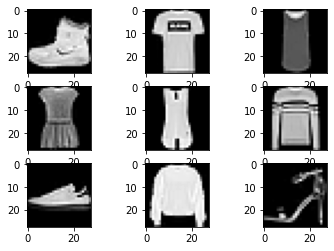

In [16]:
plotImage(9, train_X)

Now we will create the model with the CNN class we created earlier.

In [17]:
batch_size = 512
num_classes = 10
epochs = 30

NN = CNN(batch_size, epochs, num_classes)
NN.createCNN(32)

Create a summary of our current model.

In [18]:
NN.getModelSummary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               692352    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

In [19]:
hist = NN.CNN_model.fit(x=train_X, y=train_Y,
	validation_data=(test_X, test_Y),
	batch_size=batch_size, epochs=epochs)

Epoch 1/30
118/118 [==============================] - 27s 222ms/step - loss: 1.2541 - accuracy: 0.5318 - val_loss: 0.8203 - val_accuracy: 0.6738
Epoch 2/30
118/118 [==============================] - 27s 225ms/step - loss: 0.7601 - accuracy: 0.7149 - val_loss: 0.6104 - val_accuracy: 0.7630
Epoch 3/30
118/118 [==============================] - 27s 227ms/step - loss: 0.6696 - accuracy: 0.7469 - val_loss: 0.5780 - val_accuracy: 0.7641
Epoch 4/30
118/118 [==============================] - 27s 226ms/step - loss: 0.6215 - accuracy: 0.7681 - val_loss: 0.5634 - val_accuracy: 0.7617
Epoch 5/30
118/118 [==============================] - 27s 226ms/step - loss: 0.5887 - accuracy: 0.7829 - val_loss: 0.5121 - val_accuracy: 0.8081
Epoch 6/30
118/118 [==============================] - 27s 226ms/step - loss: 0.5537 - accuracy: 0.7969 - val_loss: 0.4837 - val_accuracy: 0.8175
Epoch 7/30
118/118 [==============================] - 26s 224ms/step - loss: 0.5280 - accuracy: 0.8072 - val_loss: 0.5182 - val_ac

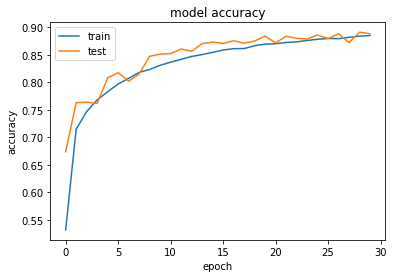

In [21]:
plotModelAcc(hist)

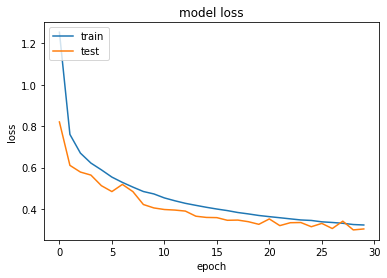

In [22]:
plotModelLoss(hist)

In [23]:
score = NN.CNN_model.evaluate(test_X, test_Y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.3029 - accuracy: 0.8885
Test loss: 0.30291038751602173
Test accuracy: 0.8884999752044678


Here we plot out some of the incorrect examples, if you would like to check on the correct prediction change the parameter into True and rerun it.

Found 1216 incorrect labels


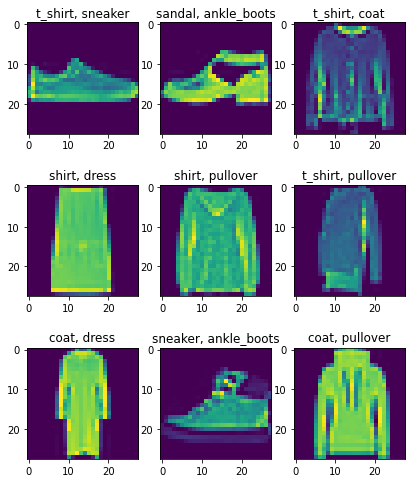

In [31]:
predicted_classes = NN.CNN_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
test_labels = np.argmax(test_Y, axis=1)

plot_predictions(test_X, predicted_classes, test_labels, False)

## What's next? 

Now that we have a model that perform decently well. The next question you want to ask is how we can improve the model. 

- Implement cross fold validtaion
- Experiment with different layer setup (Add more conv2d layer or hidden layer, use batchnormalization, setup learning rate decay)
- calculate your own evaluation metrics (Confusion matrix, Precision and Recall etc...)
- Perform hyperparameter tuning
- Speed up training time with TPU/GPU

### Extra 

We will plot out the fashion MNIST dataset with the help of TSNE and PCA.

Code credits to Manish Pathak [Introduction to t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne)

In [47]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

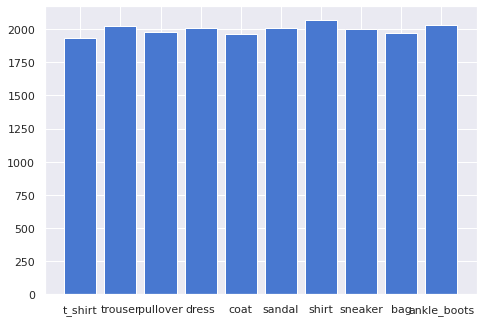

In [50]:
# load dataset
(xT, yT), (xTest, yTest) = tf.keras.datasets.fashion_mnist.load_data()
# in order to speed up the time we will only take a subset
subsetX = xT[0:20000].copy()
subsetY = yT[0:20000].copy()

# in order to perform PCA on the data we will flatten the image data with reshape
subsetX = subsetX.reshape(20000, 784)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
labels = [np.sum(subsetY==0),np.sum(subsetY==1),np.sum(subsetY==2),np.sum(subsetY==3),np.sum(subsetY==4), np.sum(subsetY==5), np.sum(subsetY==6), np.sum(subsetY==7), np.sum(subsetY==8), np.sum(subsetY==9)]
ax.bar(langs,labels)
plt.show()


In [51]:
subsetX.shape

(20000, 784)

Now that we know the subset of dataset is pretty balance, we can now perform PCA and TSNE to visualize the subset of data.

In [52]:
random_state = 123 
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(subsetX)

fashion_pca_tsne = TSNE(random_state=random_state).fit_transform(pca_result_50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [53]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(4.8746395, 19.618544, '0'),
  Text(27.923172, 57.239418, '1'),
  Text(18.541862, -41.274776, '2'),
  Text(48.923916, 16.536692, '3'),
  Text(33.978954, -35.27572, '4'),
  Text(-36.370136, 4.0432644, '5'),
  Text(14.288283, -19.536564, '6'),
  Text(-61.021793, -14.911084, '7'),
  Text(-19.406372, -34.140167, '8'),
  Text(-39.121746, 43.90916, '9')])

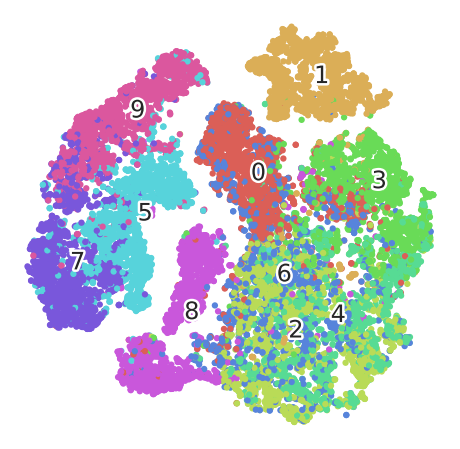

In [54]:
fashion_scatter(fashion_pca_tsne, subsetY)

A quick demonstartion of how convolution 2d layer works.

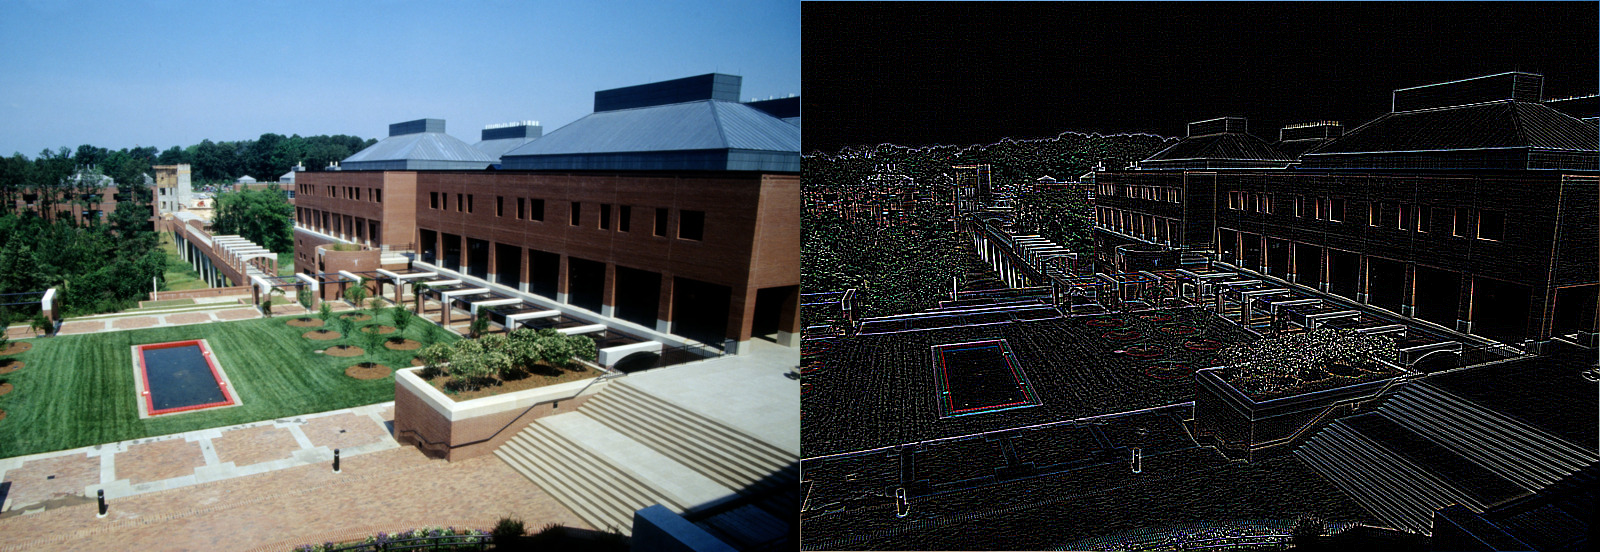

In [66]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter
from skimage import io

url = "https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg"

image = io.imread(url)
original_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
original_image = Image.fromarray(original_image)
conv2d_image = original_image.filter(ImageFilter.Kernel(
    size=(3, 3),
    kernel=[-1, -1, -1, -1, 8, -1, -1, -1, -1],
    scale=1
))

np.asarray( original_image, dtype="int32" )
final_frame = cv.hconcat((np.asarray( original_image, dtype="int32" ), np.asarray( conv2d_image, dtype="int32" )))
cv2_imshow(final_frame)